# [Gym_Trading](https://github.com/myao9494/gym_trading)

In [1]:
import pandas as pd
import gym_trading
import gym
import sys
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

import baselines.common.tf_util as U
import baselines.deepq.utils as UT


from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer
from baselines.common.schedules import LinearSchedule

C:\Users\mineo\Anaconda2\envs\gym_test\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


まず、csvファイルのアドレスを指定します。

-----------------
First, define the address for the CSV data

-----------------
csvファイルの仕様は、  
Open	High	Low	Close  
と思われる


In [2]:
csv = "data/EURUSD60.csv"

# OpenAI Gym環境を作成する（カスタマイズされた環境）

initialise_simulator（）はenv.make（ 'trading-v0'）の後に呼び出さなければなりません。  
この関数内では、次の引数を指定します

* **csv_name**: Address of the data


* **trade_period**: (int), 取引毎の最大期間（最大で、どのぐらいの期間ホールドするか？）Max of duration of each trades. *Default: 1000*


* **train_split**: (float), トレーニング用のデータの割合（残りはテスト用）Percentage of data set for training. *Default: 0.7*

In [3]:
env = gym.make('trading-v0')
env.initialise_simulator(csv, trade_period=50, train_split=0.7)#初期はtrade_period＝50


C:\Users\mineo\Anaconda2\envs\gym_test\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


                       Return       ATR  Open Trade  Duration Trade
Date_Time                                                          
2013-12-02 02:00:00  0.421251  0.355142         0.0             0.0
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# States map
states_mapは、時間刻みの半分間隔（分足なら30秒）の特徴の極値で囲まれた、離散化された観測空間です。  
また、取引期間とアクティブな取引のブール値を使用します。この観測値は、アルゴリズムが実行されている間の微分です。 

---------------

states_map is a discretized observation space bounded by the extreme values of features with an interval of 0.5. Also I use trade duration and boolean of active trade. This observations are dinamical, while the algorithm runs. 

In [4]:
env.sim.states

array([[ 0.42125144,  0.35514246,  0.        ,  0.        ],
       [ 1.7094119 ,  0.45689009,  0.        ,  0.        ],
       [-0.59190109,  0.45925152,  0.        ,  0.        ],
       ...,
       [-1.00049976, -0.45976391,  0.        ,  0.        ],
       [-0.20124835, -0.51999441,  0.        ,  0.        ],
       [ 0.31455146, -0.61636501,  0.        ,  0.        ]])

# The magic (Deep Q-Network)

Baselines OpenAIのポイントは、強化学習アルゴリズムの高品質な実装です。強化取引のための多くのプロジェクトは、独自の実装を使用しているため、小さなバグやメンテナンス/改善が困難です。

このトピックを掘り下げるには、多くの優れたリソースがあります。しかし、Q_learningとDQNの核心は次の図で表現することができます

-------------------------

The point of Baselines OpenAI is set of high-quality implementations of reinforcement learning algorithms. A lot of projects for reinforcement trading uses their own implementations, causing small bugs or hard to maintenance/improvement.

There are a lot of good resources to drill down on this topic. 
But well above, the core of Q_learning and DQNs can express with the next diagrams

![Image of DQN](https://raw.githubusercontent.com/udacity/deep-learning/master/reinforcement/assets/deep-q-learning.png)


![Image of Q-Network](https://raw.githubusercontent.com/udacity/deep-learning/master/reinforcement/assets/q-network.png)


### Learning resources:

http://karpathy.github.io/2016/05/31/rl/

http://minpy.readthedocs.io/en/latest/tutorial/rl_policy_gradient_tutorial/rl_policy_gradient.html

http://pemami4911.github.io/blog/2016/08/21/ddpg-rl.html

http://kvfrans.com/simple-algoritms-for-solving-cartpole/

https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149

https://dataorigami.net/blogs/napkin-folding/79031811-multi-armed-bandits


## Set the model 
なので、さっそくやってみよう！まずは、ネットワークをセットします。  
【ネットワーク層の説明】  
out = layers.fully_connected(層のインプット, num_outputs：アウトプットの数, activation_fn=tf.nn.tanh（活性化関数：ここでは双曲線関数、ちなみにデフォルト値はReLU関数）)  

--------------
So, let's get our hands dirty. First set our network

In [5]:
def model(inpt, num_actions, scope, reuse=False):
    """This model takes as input an observation and returns values of all actions."""
    with tf.variable_scope(scope, reuse=reuse):
        out = inpt
        out = layers.fully_connected(out, num_outputs=128, activation_fn=tf.nn.tanh)
        out = layers.fully_connected(out, num_outputs=64, activation_fn=tf.nn.tanh)
        out = layers.fully_connected(out, num_outputs=32, activation_fn=tf.nn.tanh)
        out = layers.fully_connected(out, num_outputs=num_actions, activation_fn=None)
        return out

また、すべてのエピソードの最後に使用するrun_test関数を定義する

------------
And define run_test function to use in the end of every episode

In [6]:
def run_test(env, act, episodes=1, final_test=False):
    obs = env.reset(train=False)
    start = env.sim.train_end_index + 1
    end = env.sim.count - 2

    for episode in range(episodes):
        done = False
        while done is False:
            action = act(obs[None])
            obs, reward, done, info = env.step(action)

        if not final_test:
            journal = pd.DataFrame(env.portfolio.journal)
            profit = journal["Profit"].sum()
            return env.portfolio.average_profit_per_trade, profit
        else:
            print("Training period  %s - %s" % (env.sim.date_time[start], env.sim.date_time[end]))
            print("Average Reward is %s" % (env.portfolio.average_profit_per_trade))

    if final_test:
        env.generate_summary_stats()


## Running the enviroment!

この時点で、私たちは環境を立ち上げてエピソードを実行することができます。 最も重要なのは次のとおりです。

* 私たちが望む報酬でepisode_rewardsを設定します。たとえば、各取引を最大限にしたい場合：episode_rewards [-1] + = rew
* 解決された関数を設定します。 関数の結果が真になると、トレーニングは停止します。 
    例：is_solved = np.mean（episode_rewards [-101：-1]）> 1000またはt == 100000
* deepq.build_trainをインスタンス化します。 それがOpenAIのベースラインの中核です。

----------------

At this point, we can start up the enviroment and run the episodes. The most important is:

* Set the `episode_rewards` with the reward that we want. For example if we want maximice each trade: `episode_rewards[-1] += rew`
* Set the solved function. The training will stop when the outcome of function get True. For example: `is_solved = np.mean(episode_rewards[-101:-1]) > 1000 or t == 100000`
* Instanciate `deepq.build_train`. That is the core of Baseline of OpenAI.

### `build_train` Creates the train function:

#### パラメータ
* make_obs_ph：str - > tf.placeholderまたはTfInput - >名前を取り、その名前の入力のプレースホルダを作成する関数

* q_func：（tf.Variable、int、str、bool） - > tf.Variable - >次の入力を受け取るモデル：
    1. observation_in：オブジェクト - >観測プレースホルダの出力
    1. num_actions：int - >アクション数
    1. scope：str
    1. reuse：bool - >は外部変数scopeに渡され、すべてのアクションの値とともにテンソルの形状（batch_size、num_actions）を返します。
    
    
* num_actions：int - >アクション数

* reuse：bool - >グラフ変数を再利用するかどうか

* optimizer：tf.train.Optimizer - >オプティマイザをQ-learningの目的に使用します。

* grad_norm_clipping：floatまたはNone->この勾配ノルムをクリップします。 Noneの場合、クリッピングは実行されません。

* gamma：float - >割引率。

* double_q：bool - > trueの場合はDouble Q Learning（https://arxiv.org/abs/1509.06461)を使用します。一般に、有効にすることをお勧めします。

* scope：strまたはVariableScope - > variable_scopeのオプションスコープ。

* reuse：boolまたはNone - >変数を再利用する必要があるかどうか。スコープを再利用できるようにする必要があります。

#### 戻り値
* act：（tf.Variable、bool、float） - > tf.Variable - >与えられた観測を選択して処理する関数。

* train：（オブジェクト、np.array、np.array、オブジェクト、np.array、np.array） - > np.array - > Bellmanの式の誤差を最適化します。詳細はファイルの先頭を参照してください。

* update_target：（） - >（） - >最適化されたQ関数からターゲットQ関数にパラメータをコピーします。デバッグ：{str：function} - > q_valuesのようなデバッグデータを出力する一連の関数。


----------------------------

#### Parameters

* make_obs_ph: str -> tf.placeholder or TfInput -> a function that takes a name and creates a placeholder of input with that name

* q_func: (tf.Variable, int, str, bool) -> tf.Variable -> the model that takes the following inputs:
    * observation_in: object -> the output of observation placeholder
    * num_actions: int -> number of actions
    * scope: str
    * reuse: bool -> should be passed to outer variable scope and returns a tensor of shape (batch_size, num_actions) with values of every action.

* num_actions: int -> number of actions

* reuse: bool -> whether or not to reuse the graph variables

* optimizer: tf.train.Optimizer -> optimizer to use for the Q-learning objective.

* grad_norm_clipping: float or None -> clip gradient norms to this value. If None no clipping is performed.

* gamma: float -> discount rate.

* double_q: bool -> if true will use Double Q Learning (https://arxiv.org/abs/1509.06461).In general it is a good idea to keep it enabled.

* scope: str or VariableScope -> optional scope for variable_scope.

* reuse: bool or None -> whether or not the variables should be reused. To be able to reuse the scope must be given.

#### Returns

* act: (tf.Variable, bool, float) -> tf.Variable -> function to select and action given observation.

* train: (object, np.array, np.array, object, np.array, np.array) -> np.array  -> optimize the error in Bellman's equation.See the top of the file for details.

* update_target: () -> () -> copy the parameters from optimized Q function to the target Q function.
debug: {str: function} -> a bunch of functions to print debug data like q_values.



INFO:tensorflow:Restoring parameters from ./test_model/test_model


C:\Users\mineo\Anaconda2\envs\gym_test\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\mineo\Anaconda2\envs\gym_test\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-------------------------------------
steps                     | 2138
episodes                  | 1
% time spent exploring    | 79
--
mean episode reward       | nan
Total operations          | 365
Avg duration trades       | 3.68
Total profit              | -770.0
Avg profit per trade      | -2.123
--
Total profit test:        > -733.7
Avg profit per trade test > -4.341
-------------------------------------
-------------------------------------
steps                     | 4277
episodes                  | 2
% time spent exploring    | 58
--
mean episode reward       | -2946.7
Total operations          | 397
Avg duration trades       | 2.46
Total profit              | -727.0
Avg profit per trade      | -2.177
--
Total profit test:        > -750.0
Avg profit per trade test > -3.692
-------------------------------------
-------------------------------------
steps                     | 6416
episodes                  | 3
% time spent exploring    | 37
--
mean episode reward       | -2348.5

-------------------------------------
steps                     | 44918
episodes                  | 21
% time spent exploring    | 2
--
mean episode reward       | -1025.0
Total operations          | 34
Avg duration trades       | 6.47
Total profit              | -59.0
Avg profit per trade      | -1.885
--
Total profit test:        > -42.2
Avg profit per trade test > -2.671
-------------------------------------
-------------------------------------
steps                     | 47057
episodes                  | 22
% time spent exploring    | 2
--
mean episode reward       | -846.5
Total operations          | 28
Avg duration trades       | 1.82
Total profit              | -82.0
Avg profit per trade      | -4.882
--
Total profit test:        > -55.4
Avg profit per trade test > -5.422
-------------------------------------
-------------------------------------
steps                     | 49196
episodes                  | 23
% time spent exploring    | 2
--
mean episode reward       | -801.0


-------------------------------------
steps                     | 87698
episodes                  | 41
% time spent exploring    | 2
--
mean episode reward       | 1083.4
Total operations          | 48
Avg duration trades       | 43.15
Total profit              | 16.0
Avg profit per trade      | 0.078
--
Total profit test:        > -244.3
Avg profit per trade test > -9.5
-------------------------------------
-------------------------------------
steps                     | 89837
episodes                  | 42
% time spent exploring    | 2
--
mean episode reward       | 1126.4
Total operations          | 48
Avg duration trades       | 43.15
Total profit              | 135.0
Avg profit per trade      | 4.053
--
Total profit test:        > -173.8
Avg profit per trade test > -9.084
-------------------------------------
-------------------------------------
steps                     | 91976
episodes                  | 43
% time spent exploring    | 2
--
mean episode reward       | 863.2
Tot

-------------------------------------
steps                     | 130478
episodes                  | 61
% time spent exploring    | 2
--
mean episode reward       | 724.4
Total operations          | 31
Avg duration trades       | 5.39
Total profit              | 142.0
Avg profit per trade      | 5.445
--
Total profit test:        > -296.7
Avg profit per trade test > -4.66
-------------------------------------
-------------------------------------
steps                     | 132617
episodes                  | 62
% time spent exploring    | 2
--
mean episode reward       | 856.3
Total operations          | 64
Avg duration trades       | 18.91
Total profit              | -50.0
Avg profit per trade      | 0.448
--
Total profit test:        > -276.1
Avg profit per trade test > -7.936
-------------------------------------
-------------------------------------
steps                     | 134756
episodes                  | 63
% time spent exploring    | 2
--
mean episode reward       | 1115.2


Total profit test:        > -238.7
Avg profit per trade test > -10.648
-------------------------------------
-------------------------------------
steps                     | 173258
episodes                  | 81
% time spent exploring    | 2
--
mean episode reward       | 1951.0
Total operations          | 48
Avg duration trades       | 42.08
Total profit              | -75.0
Avg profit per trade      | 1.304
--
Total profit test:        > -249.0
Avg profit per trade test > -11.6
-------------------------------------
-------------------------------------
steps                     | 175397
episodes                  | 82
% time spent exploring    | 2
--
mean episode reward       | 1865.9
Total operations          | 48
Avg duration trades       | 43.19
Total profit              | -22.0
Avg profit per trade      | 0.273
--
Total profit test:        > -243.8
Avg profit per trade test > -10.242
-------------------------------------
-------------------------------------
steps                

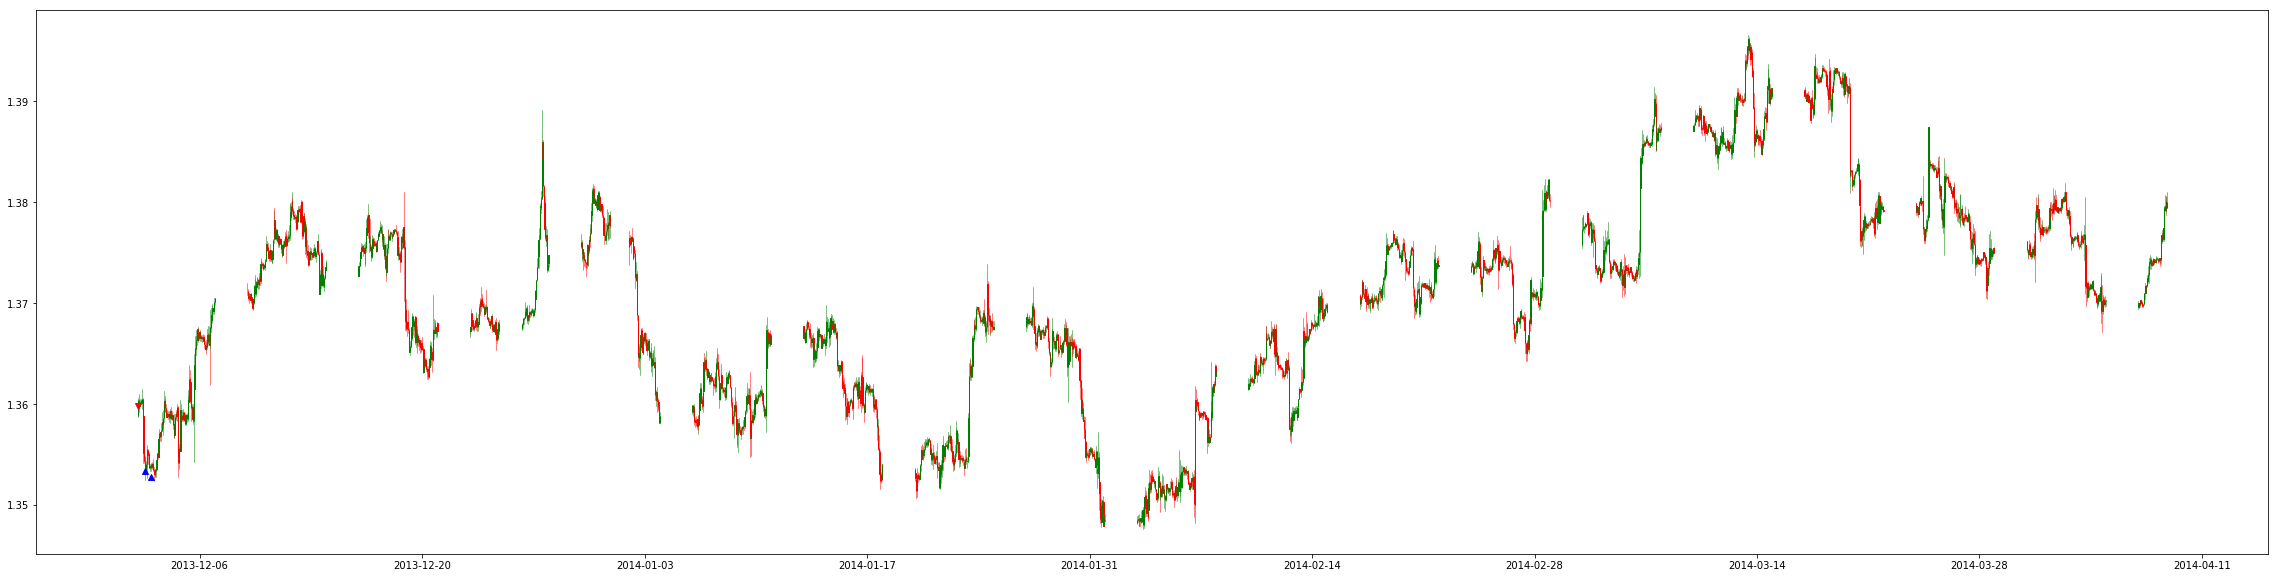

[ { 'Entry Price': 1.35881,
    'Entry Time': Timestamp('2013-12-02 03:00:00'),
    'Exit Price': 1.3543399999999999,
    'Exit Time': Timestamp('2013-12-02 12:00:00'),
    'Profit': 41.700000000001964,
    'Trade Duration': 9,
    'Type': 'SELL',
    'reward': 33.70000000000062},
  { 'Entry Price': 1.3543399999999999,
    'Entry Time': Timestamp('2013-12-02 13:00:00'),
    'Exit Price': 1.3537700000000001,
    'Exit Time': Timestamp('2013-12-02 21:00:00'),
    'Profit': -8.699999999997374,
    'Trade Duration': 8,
    'Type': 'BUY',
    'reward': -9.799999999997919},
  { 'Entry Price': 1.3537700000000001,
    'Entry Time': Timestamp('2013-12-02 22:00:00'),
    'Exit Price': 1.35867,
    'Exit Time': Timestamp('2013-12-03 17:00:00'),
    'Profit': 45.99999999999905,
    'Trade Duration': 19,
    'Type': 'BUY',
    'reward': 39.1999999999989}]
Training period  2014-04-08 20:00:00 - 2014-05-30 22:00:00
Average Reward is -5.902222222222138
SUMMARY STATISTICS
Total Trades Taken:  44
Total 

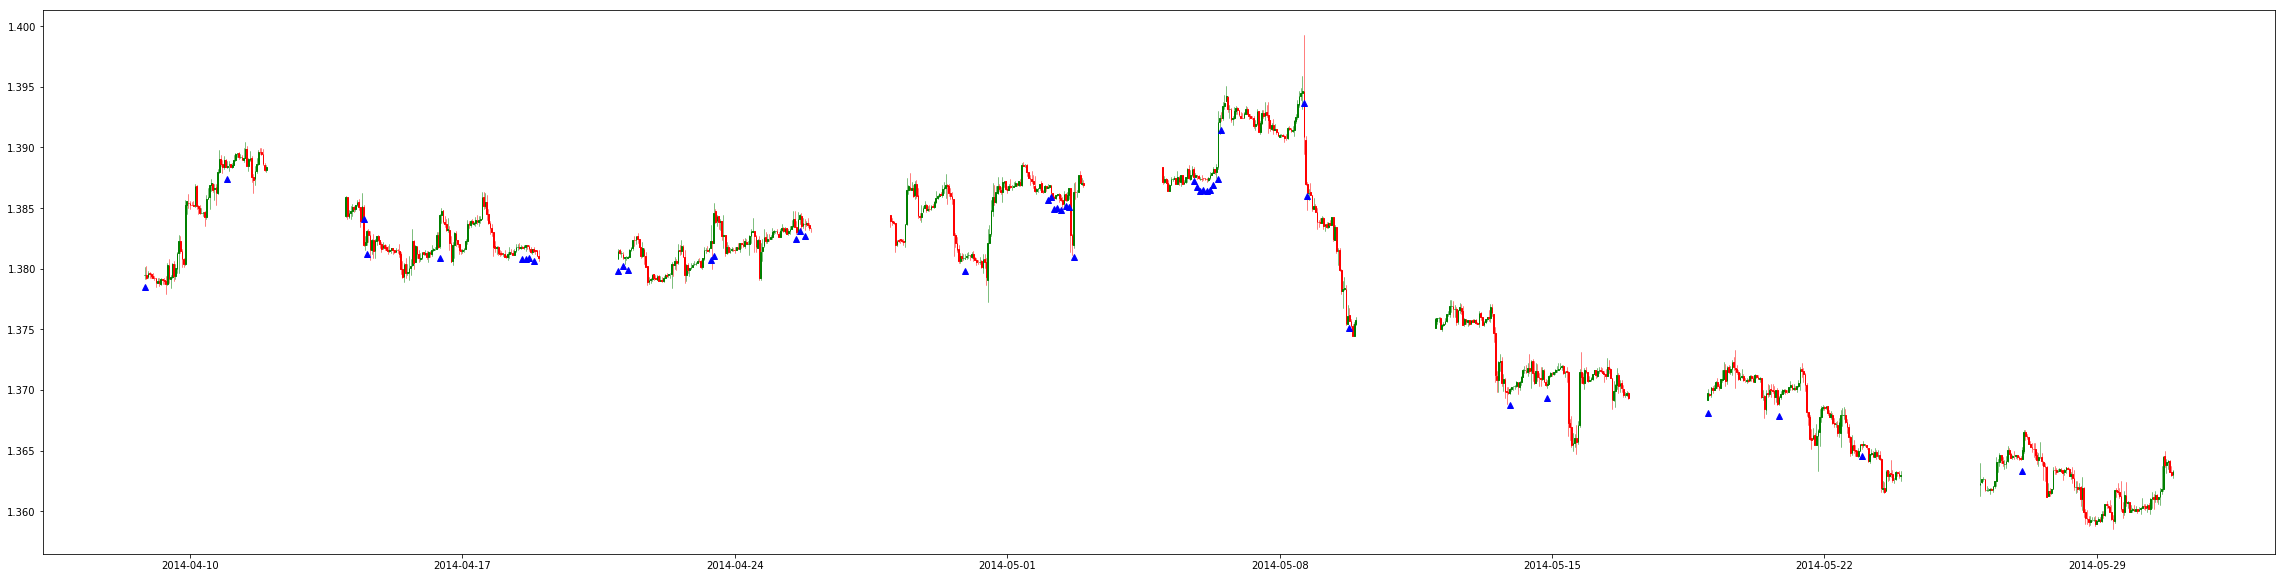

[ { 'Entry Price': 1.3795,
    'Entry Time': Timestamp('2014-04-08 20:00:00'),
    'Exit Price': 1.3884100000000001,
    'Exit Time': Timestamp('2014-04-10 22:00:00'),
    'Profit': 86.10000000000196,
    'Trade Duration': 50,
    'Type': 'BUY',
    'reward': 91.40000000000114},
  { 'Entry Price': 1.38839,
    'Entry Time': Timestamp('2014-04-10 23:00:00'),
    'Exit Price': 1.38514,
    'Exit Time': Timestamp('2014-04-14 10:00:00'),
    'Profit': -35.49999999999975,
    'Trade Duration': 35,
    'Type': 'BUY',
    'reward': -47.6000000000013},
  { 'Entry Price': 1.3851,
    'Entry Time': Timestamp('2014-04-14 11:00:00'),
    'Exit Price': 1.3822,
    'Exit Time': Timestamp('2014-04-14 12:00:00'),
    'Profit': -31.999999999999027,
    'Trade Duration': 1,
    'Type': 'BUY',
    'reward': -34.60000000000052},
  { 'Entry Price': 1.38222,
    'Entry Time': Timestamp('2014-04-14 13:00:00'),
    'Exit Price': 1.38182,
    'Exit Time': Timestamp('2014-04-16 09:00:00'),
    'Profit': -6.9999

In [7]:
with U.make_session(8):
    
    act, train, update_target, debug = deepq.build_train(
        make_obs_ph=lambda name: UT.BatchInput(env.observation_space.shape, name=name),
        q_func=model,
        num_actions=env.action_space.n,
        optimizer=tf.train.AdamOptimizer(learning_rate=5e-4),
    )
    UT.load_state( './test_model/test_model')
    replay_buffer = ReplayBuffer(50000)
    # Create the schedule for exploration starting from 1 (every action is random) down to
    # 0.02 (98% of actions are selected according to values predicted by the model).
    exploration = LinearSchedule(schedule_timesteps=10000, initial_p=1.0, final_p=0.02)
    # Initialize the parameters and copy them to the target network.
    U.initialize()
    update_target()

    episode_rewards = [0.0]
    obs = env.reset()
    l_mean_episode_reward = []
    for t in itertools.count():
        # Take action and update exploration to the newest value
        action = act(obs[None], update_eps=exploration.value(t))[0]

        new_obs, rew, done, _ = env.step(action)

        # Store transition in the replay buffer.
        replay_buffer.add(obs, action, rew, new_obs, float(done))

        obs = new_obs

        episode_rewards[-1] += rew

        is_solved = np.mean(episode_rewards[-101:-1]) > 5000 or t >= 3000000
        is_solved = is_solved and len(env.portfolio.journal) > 2
        
        if done:

            journal = pd.DataFrame(env.portfolio.journal)
            profit = journal["Profit"].sum()

            try:
                print("-------------------------------------")
                print("steps                     | {:}".format(t))
                print("episodes                  | {}".format(len(episode_rewards)))
                print("% time spent exploring    | {}".format(int(100 * exploration.value(t))))

                print("--")
                l_mean_episode_reward.append(round(np.mean(episode_rewards[-101:-1]), 1))

                print("mean episode reward       | {:}".format(l_mean_episode_reward[-1]))
                print("Total operations          | {}".format(len(env.portfolio.journal)))
                print("Avg duration trades       | {}".format(round(journal["Trade Duration"].mean(), 2)))
                print("Total profit              | {}".format(round(profit), 1))
                print("Avg profit per trade      | {}".format(round(env.portfolio.average_profit_per_trade, 3)))

                print("--")

                reward_test, profit = run_test(env=env, act=act)
                print("Total profit test:        > {}".format(round(profit, 2)))
                print("Avg profit per trade test > {}".format(round(reward_test, 3)))
                print("-------------------------------------")
            except Exception as e:
                print("Exception: ", e)
                # Update target network periodically.

            obs = env.reset()
            episode_rewards.append(0)



        if is_solved:
            # Show off the result
            env.generate_summary_stats()
            run_test(env, act, final_test=True)
            break

        else:
            # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
            if t > 500:
                obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(32)
                train(obses_t, actions, rewards, obses_tp1, dones, np.ones_like(rewards))
            if t % 500 == 0:
                update_target()
                UT.save_state( './test_model/test_model')


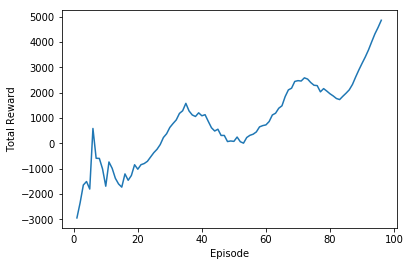

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(l_mean_episode_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

### It converges!
Time to implement your own strategy :) 

And remember, be careful of overfitting.
